In [2]:
import pandas as pd
%config InlineBackend.figure_format = 'retina'

In [2]:
!wget https://www.proteinatlas.org/download/proteinatlas.xml.gz
!wget https://www.proteinatlas.org/download/normal_tissue.tsv.zip
!wget https://www.proteinatlas.org/download/pathology.tsv.zip
!wget https://www.proteinatlas.org/download/subcellular_location.tsv.zip
!wget https://www.proteinatlas.org/download/rna_tissue_consensus.tsv.zip

In [62]:
!python parse_hpa_xml.py proteinatlas.xml.gz | gzip -c > proteinatlas.tsv.gz

In [10]:
df = pd.read_csv('proteinatlas.tsv.gz',sep='\t',header=None,engine='c')
df.columns = ['Gene name','Gene','UniProt','Antibody','Tissue','Cell','Staining','Sex','Age','Patient','URL']

normal_tissue = pd.read_csv('normal_tissue.tsv',sep='\t')
normal_tissues = set(normal_tissue['Tissue'].unique())
df = df.loc[df['Tissue'].isin(normal_tissues)]

df['Level'] = df['Staining'].map({'not detected': 0, 'low': 1, 'medium': 2, 'high': 3})

df.sort_values(['Gene','URL','Level'],inplace=True)
df.drop_duplicates(subset=['Gene','URL'],keep='last',inplace=True)
df.drop(columns=['Cell','Level'],inplace=True)

df[['Batch','Slide','Well']] = df['URL'].str.extract(image_pattern)
df.dropna(subset=['Batch'],inplace=True)
df['Image'] = df['Slide'] + '_' + df['Well']

df = df.merge(normal_tissue[['Gene','Tissue','Reliability']].drop_duplicates(),on=['Gene','Tissue'],how='left')

rna_expression = pd.read_csv('rna_tissue_consensus.tsv',sep='\t')
df = df.merge(rna_expression[['Gene','Tissue','nTPM']],on=['Gene','Tissue'],how='left')

df['nTPM'].fillna(0, inplace=True)
df['Age'].fillna(-1, inplace=True)

df.set_index('Image',inplace=True)

df.to_csv('hpa_v21.csv.gz')

df

<AxesSubplot:>

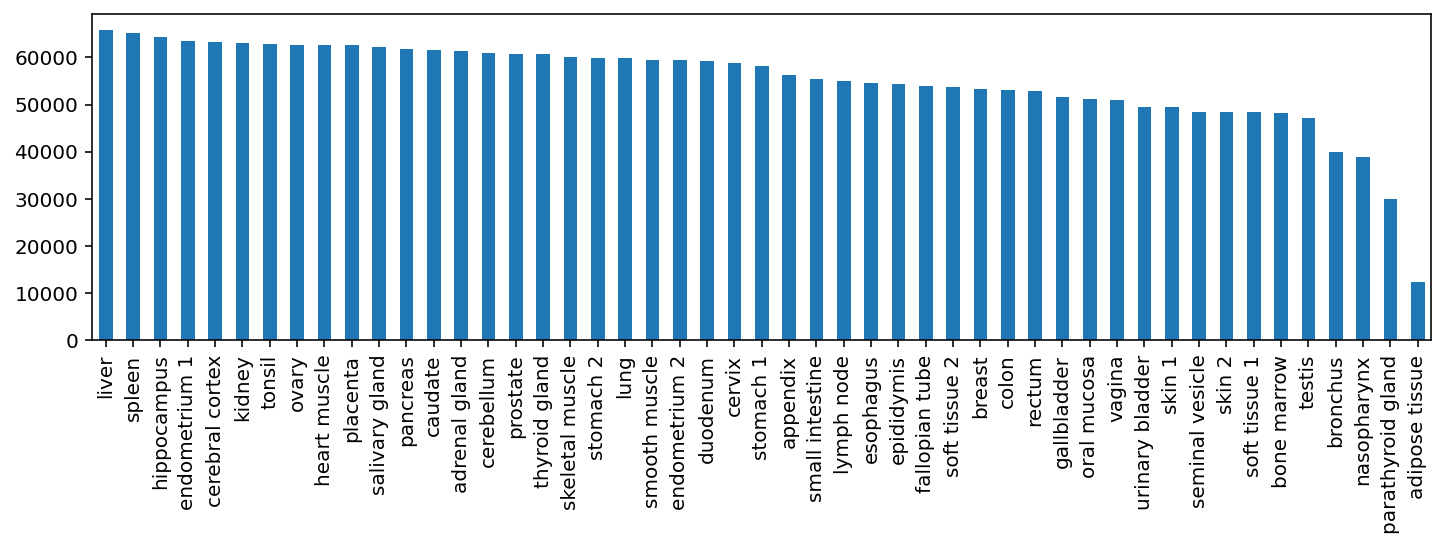

In [122]:
df['Tissue'].value_counts().plot(kind='bar',figsize=(12,3))